## Problem Statement

Dalam masalah ini, akan dilatih model CNN untuk mengklasifikasikan apakah suatu gambar menunjukkan objek cat, deer, dog, dan horse.
Dataset 4 animal classification merupakan kumpulan data visi komputer standar yang melibatkan pengklasifikasian gambar berisi cat, deer, dog, dan horse. 
Dataset inilah yang kemudian digunakan untuk mengembangkan jaringan saraf convolutional untuk mengklasifikasikan foto
Rumusan masalah:
- Cara memuat dan menyiapkan foto cat, deer, dog, dan horse untuk pemodelan.
- Bagaimana mengembangkan jaringan saraf convolutional untuk klasifikasi foto dari awal dan meningkatkan kinerja model.
- Bagaimana mengembangkan model klasifikasi foto menggunakan transfer learning.

In [1]:
# library

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers 
from tensorflow.keras.applications import InceptionResNetV2
import os
import zipfile
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

## Data Acquisition

Melakukan mount google drive agar dapat melakukan akses ke Google Drive

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Mengubah directory dan set environment sebagai lokasi kerja file ipynb dan sebagai alamat tempat penyimpanan dataset yang akan digunakan

In [3]:
# change directory
%cd  /content/gdrive/My Drive/MSIB/CV/Ujian Praktik/

#set environment
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/MSIB/CV/Ujian Praktik/"

/content/gdrive/My Drive/MSIB/CV/Ujian Praktik


Download dataset dari API Kaggle dan disimpan di environment yang telah ditentukan

In [4]:
#donwload dataset dari API Kaggle
!kaggle competitions download -c 4-animal-classification

4-animal-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip dataset dan extract ke directory yang telah ditentukan: /content/gdrive/My Drive/MSIB/CV/Ujian Praktik/. Directory ini terbagi atas folder train dan test dan file submission csv. Folder train memiliki beberapa subfolder: cat, deer, dog, dan horse.

In [5]:
data_path = "/content/gdrive/My Drive/MSIB/CV/Ujian Praktik/"

In [6]:
#unzip
with zipfile.ZipFile(data_path + "4-animal-classification.zip", 'r') as zipObj:
  zipObj.extractall(data_path + "Data")
  zipObj.close()

In [8]:
test_dir = data_path + "Data/test/test" 
raw_train_dir = data_path + "Data/train"

## Data Preprocessing

1. Visualisasi data

Mencari informasi berapa total images dari masing-masing class di data train dan data test

In [9]:
classes = []
nums = []
data = {'Nama class':[],'Jumlah data':[]}

for i in os.listdir(raw_train_dir):
    nums.append(len(os.listdir(raw_train_dir+'/'+i)))
    classes.append(i)

data['Nama class']+=classes
data['Jumlah data']+=nums

df = pd.DataFrame(data)
df = df.sort_values(by=['Jumlah data'], ascending=False)
df

,Nama class,Jumlah data
2,dog,900
0,cat,700
1,deer,600
3,horse,600


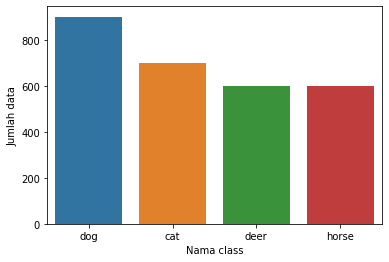

In [10]:
sns.barplot(x=df['Nama class'], y=df['Jumlah data'])

Dari 4 class, dapat dilihat bahwa data image terbanyak berada di class dog sebanyak 900 images, kemudian disusul class cat sebanyak 700 images, kemudian deer dan horse berada di tingkat yang sama, yaitu sebanyak 600 images

In [11]:
total_train = 0
for i in os.listdir(raw_train_dir):
    total_train += (len(os.listdir(raw_train_dir+'/'+i)))

print('There are {} number of images in train directory.'.format(total_train))
print('Total test images:', len(os.listdir(test_dir)))

There are 2800 number of images in train directory.
Total test images: 729


Melihat beberapa images untuk masing-masing class agar mendapatkan sense lebih baik.

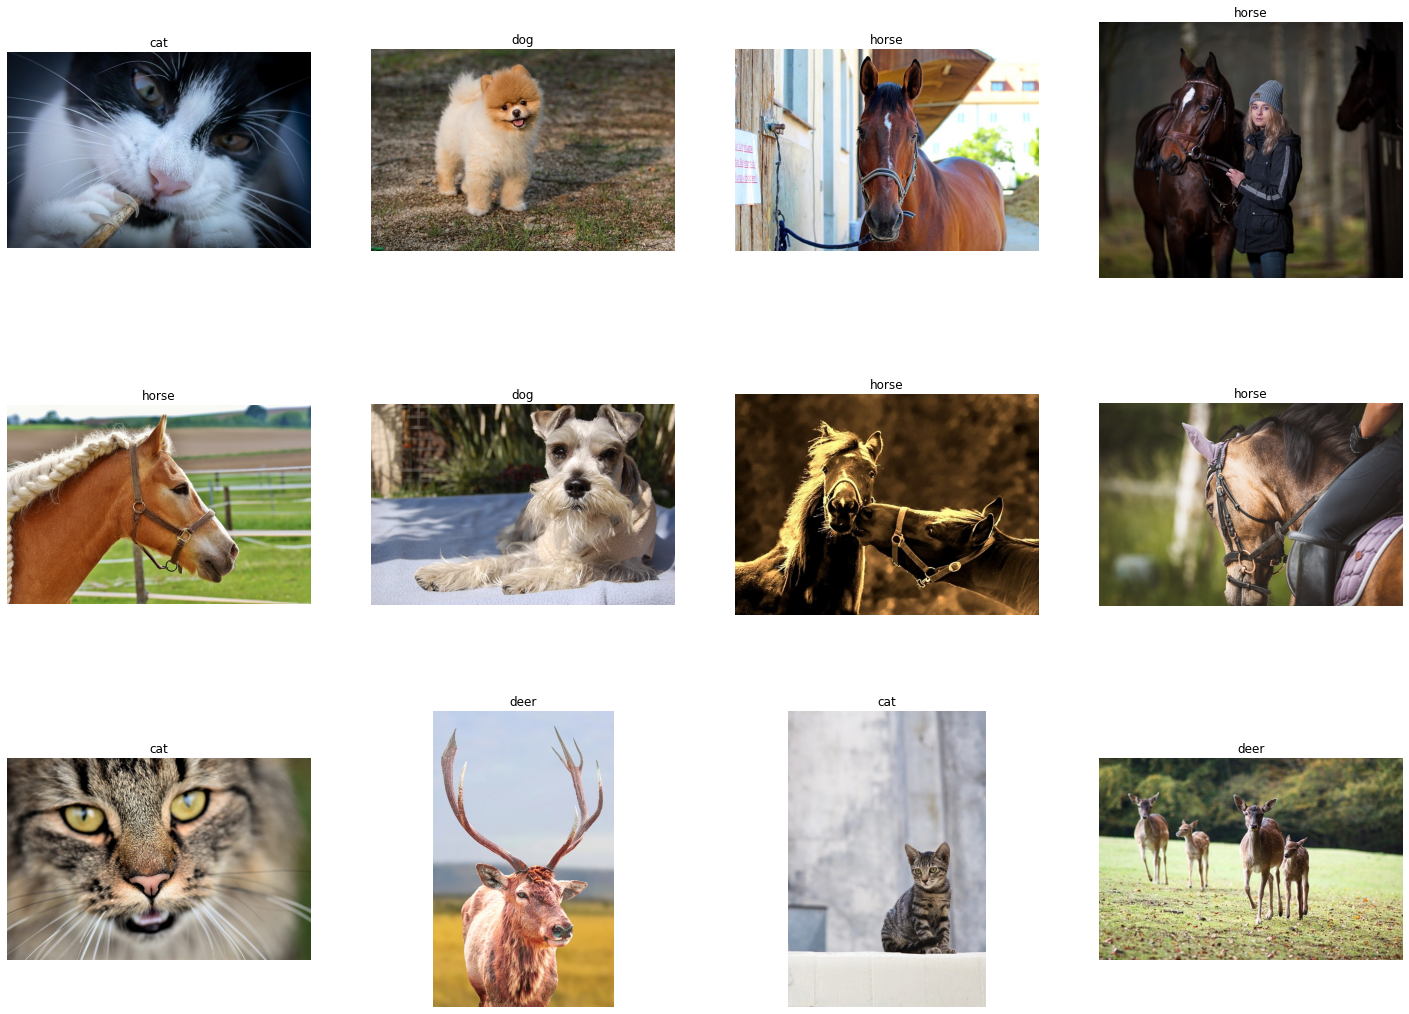

In [12]:
classes = os.listdir(raw_train_dir)

plt.figure(figsize=(25 , 25))
for x in range(12):
    i = random.randint(0,3)                    
    
    # getting the class
    images = os.listdir(raw_train_dir+'/'+classes[i])
    j = random.randint(0,600)                  
    
    # getting the image
    image = cv2.imread(raw_train_dir+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(4, 4, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

2. Split data train dan data valid

Install library split-folders. Sesuai namanya, split folders akan membagi file (seperti gambar) menjadi train, validation, dan test (dataset) folders.

In [13]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Melakukan split data train dan data valid dengan data input berasal dari path data: "/content/gdrive/My Drive/MSIB/CV/Ujian Praktik/Data/train" dan hasil split akan disimpan di path: "/content/gdrive/My Drive/MSIB/CV/Ujian Praktik/Data/trainvalid" dengan perbandingan 80:20.

In [14]:
import splitfolders
input_folder = data_path + "Data/train" 
output_folder = data_path + "Data/trainvalid"
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8,0.2), group_prefix=None)

Copying files: 2800 files [00:39, 70.70 files/s] 


Variabel untuk menyimpan path data

In [15]:
train_dir = data_path + "Data/trainvalid/train" 
valid_dir = data_path + "Data/trainvalid/val" 


Melihat jumlah data train dan data valid yang telah berhasil di split

In [16]:
total_train_dir = 0
total_valid_dir = 0
for i in os.listdir(train_dir):
    total_train_dir  += (len(os.listdir(train_dir+'/'+i)))
for i in os.listdir(valid_dir):
    total_valid_dir  += (len(os.listdir(valid_dir+'/'+i)))

print('Total train images:', total_train_dir)
print('Total valid images:', total_valid_dir)

Total train images: 2240
Total valid images: 560


2. ImageDataGenerator

Penggunaan `keras.preprocessing.image.ImageDataGenerator` class dilakukan untuk mengenerate data image dari sebuah file / folder yang telah di buat sebelumnya. Dengan ini dapat menentukan generator / augmentasi seperti apa yang dapat dilakukan. 

Augmentasi data bertujuan agar mesin dapat belajar dan mengenali dari berbagai citra yang berbeda-beda sekaligus bisa dimanfaatkan untuk memperbanyak data. Pada kebanyakan kasus, penggunaan augmentasi data berhasil meningkatkan performa dari model. Peningkatan tersebut terjadi karena mesin berhasil mengenali lebih banyak objek dari bentuk dan pola yang beragam jenisnya.



In [17]:
img_height = 400
img_width = 400

Augmentasi citra pada data train dilakukan dengan melakukan rescale, horizontal flip, shift, rotation,fill_mode. Sedangkan pada data valid hanya dilakukan proses rescale pada citra. Hal ini dikarenakan model membutuhkan banyak sumber pengetahuan data train dari berbagai bentuk citra yang ada (dari hasil augmentasi) agar dapat memberikan model yang lebih baik, sedangkan data valid hanya akan digunakan untuk mencocokkan hasil klasifikasi citra berdasarkan inputan data citra menggunakan model yang telah dibangun. Data valid dan data test murni digunakan untuk penyetelan hyperparameter dan memperkirakan kinerja akhir, yaitu memperkirakan kesalahan generalisasi.

Proses augmentasi juga melibatkan normalize data. Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)


Augmentasi citra kemudian diterapkan kepada masing-masing data train dan data valid. Disetiap generator, kita menentukan source directory dari images, batch size (seberapa banyak images yang akan diproses), target_size (ukuran images)dan shuffle (shuffle data antar epochs).

In [19]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True)

val_gen = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=20, 
    shuffle=False)

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


## Modelling

Proses modelling pada tugas ini adalah menggunakan pendekatan transfer learning. Transfer Learning adalah suatu metode machine learning dimana
sebuah model yang dibuat (contohnya model deep learning)
untuk suatu tujuan, digunakan kembali untuk tujuan baru atau
tujuan lainnya. 

Penggunaan transfer learning dilakukan karena 
1.   Menghemat waktu karena existing deeplearning model yang digunakan untuk Transfer Learning sudah memiliki weight dimana didalamnya ada data training hasil training sebelumnya. 
2.   Dataset yang digunakan berjumlah tergolong sedikit untuk dilakukan pembelajaran model yang mampu menghasilkan akurasi yang baik


Transfer learning yang digunakan adalah InceptionResNetV2. Disini didefinisikan based model sebagai pre-trained-model. Parameter yang digunakan:
*   Include_top: false. Tidak menghapus full connected layers di akhir.
*   weights: imagenet. Gunakan bobot ImageNet yang telah dilatih sebelumnya untuk masing-masing model.
*   input_tensor: False. tidak menggunakan output model lain sebagai input based model saat ini
*   input_shape: (400,400,3). Membuat layer input dengan size yang ditentukan




In [20]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(400 , 400, 3))

219070464/219055592 [==============================] - 1s 0us/step


Memindahkan semua bobot layer dari yang dapat dilatih ke yang tidak dapat dilatih. Ini disebut "freeze" layer: status freeze layer tidak akan diperbarui selama pelatihan (baik saat berlatih dengan fit() atau saat berlatih dengan custom loop apa pun yang bergantung pada trainable_weights untuk menerapkan pembaruan gradien).

In [22]:
for layer in base_model.layers:
    layer.trainable = False

Modifikasi arsitektur layer:
*   Menambahkan layer flatten yang mengubah output layer menjadi 1 dimensi. 
*   Menambahkan droput layer sebesar 0.5 untuk mengurangi terjadinya overfitting
*   Menambahkan dense layer dengan fungsi aktivasi softmax dan node 4 (sesuai jumlah class) untuk output klasifikasi

Arsitektur bawaan dari basemodel ditambahkan dengan arsitektur yang dimodifikasi ini. Lalu, diterapkan ke model sekarang.

In [21]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 4 node for classification output
output_layer = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, output_layer)

Menerapkan fungsi optimasi Adam dengan learning rate yang telah ditetapkan, loss, dan metrics berupa accuracy. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) adalah sensible optimization algorithm karena mengautomasi learning-rate tuning untuk kita. Kita akan menambahkan accuracy ke `metrics` jadi model akan memonitor accuracy saat melakukan training. Fungsi loss yang digunakan adalah categorical crossentropy karena data memiliki 4 categorical

In [23]:
# tell the model what cost and optimization method to use
model.compile(optimizer = Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Melihat arsitektur model secara ringkas

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 199, 199, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 199, 199, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Kolom "output shape"  menampilkan transformasi dari setiap dimensi layer sebagai hasil dari convolution, maxpooling, batch normalization. 

Training model dengan jumlah epochs sebanyak 15. Epoch merupakan hyperparameter yang menentukan berapa kali algoritma deep learning bekerja melewati seluruh dataset.

In [25]:
# fit the model

epochs=15
r = model.fit(
  train_gen,
  steps_per_epoch = train_gen.samples // 32,
  validation_data=val_gen,
  validation_steps = val_gen.samples // 20,
  epochs=epochs
)

Epoch 1/15
70/70 [==============================] - 135s 2s/step - loss: 0.7965 - accuracy: 0.7152 - val_loss: 0.2513 - val_accuracy: 0.9571
Epoch 2/15
70/70 [==============================] - 102s 1s/step - loss: 0.3010 - accuracy: 0.9246 - val_loss: 0.1384 - val_accuracy: 0.9714
Epoch 3/15
70/70 [==============================] - 102s 1s/step - loss: 0.1843 - accuracy: 0.9567 - val_loss: 0.1013 - val_accuracy: 0.9768
Epoch 4/15
70/70 [==============================] - 102s 1s/step - loss: 0.1423 - accuracy: 0.9688 - val_loss: 0.0875 - val_accuracy: 0.9732
Epoch 5/15
70/70 [==============================] - 102s 1s/step - loss: 0.1348 - accuracy: 0.9688 - val_loss: 0.0760 - val_accuracy: 0.9768
Epoch 6/15
70/70 [==============================] - 102s 1s/step - loss: 0.0973 - accuracy: 0.9763 - val_loss: 0.0675 - val_accuracy: 0.9768
Epoch 7/15
70/70 [==============================] - 103s 1s/step - loss: 0.0848 - accuracy: 0.9795 - val_loss: 0.0629 - val_accuracy: 0.9786
Epoch 8/15
70

## Model Evaluation

Plot score loss dan accuracy pada train dan validation per epochs. Ini dilakukan untuk melihat bagaimana loss dan accuracy tiap data train dan validation setiap proses epochs pelatihan yang telah terjadi.

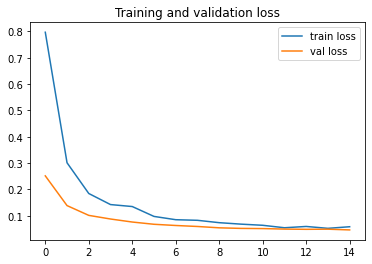

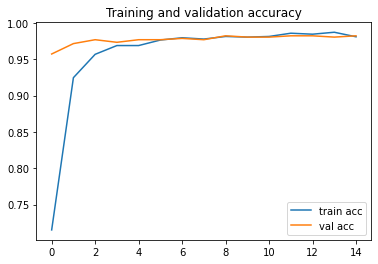

In [26]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()

Plot 1: Training adn validation loss. Plot ini memperlihatkan nilai loss data train dan validation. Data train pada epoch pertama tergolong tinggi yaitu sekitar 0.8, sedangkan pada data valid sekitar 0.3. Kemudian, seiring bertambahnya epochs pelatihan, nilai loss masing-masing data semakin mengecil dan line plot kedua data semakin mendekat. Artinya, model sudah memiliki nilai loss yang kecil.

Plot 2: Training and validation accuracy. Plot ini memperlihatkan nilai accuracy data train dan validation. Data train pada epoch pertama memiliki nilai yang rendah, namun dia perlahan naik hingga kurang lebih 0.98 sedangkan data validation memiliki nilai acc yang cennderung konstan. Hingga akhir epoch, nilai acc data train kebanyakan lebih tinggi atau sama dengan nilai data validation (jarak nilai antar data pada epoch yang sama pun tidak jauh, terbukti dari line plot kedua data yang hampir beririsan). Artinya, model yang dihasilkan sudah cukup baik.

Kedua plot ini dapat menggambarkan model yang goodfit karena hasil loss dan accuracy secara bertahap menaik dengan smooth, tidak terjadi kenaikan dan atau penurunan nilai yang curam.

Kalkulasi loss dan acc data train dan data valid

In [27]:
val_acc_loss = model.evaluate(val_gen)
print(val_acc_loss)

train_acc_loss = model.evaluate(train_gen)
print(train_acc_loss)

28/28 [==============================] - 10s 350ms/step - loss: 0.0461 - accuracy: 0.9821
[0.046059977263212204, 0.9821428656578064]
70/70 [==============================] - 91s 1s/step - loss: 0.0352 - accuracy: 0.9902
[0.035230349749326706, 0.9901785850524902]


## Submission

Menentukan directory file csv sample_submission.csv

In [28]:
sub_dir = data_path + 'Data/Sample_submission.csv'

Membaca file csv

In [29]:
df_sub = pd.read_csv(sub_dir)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


Melakukan load image seluruh data test yang bersumber dari directory test_dir yang telah ditetapkan sebelumnya. Data test tersebut kemudian di normalize, di reshape untuk menyesuaikan shape citra, dan dilakukn prediksi berdasarkan model yang telah dibangun. Hasil prediksi akan disimpan dalam array bernama label. Array tersebut di ubah menjadi list. Proses ini dilakukan berulang untuk seluruh masing-masing data test.

In [32]:
from tensorflow.keras.preprocessing.image import load_img

labels = []

for i in image_id:
    image = load_img(test_dir+'/'+str(i)+'.jpg', target_size=(400, 400))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,400,400,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))

Melihat dataframe yang telah diisikan hasil prediksi

In [33]:
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


Menyimpan dataframe ke bentuk csv di file direcotory local yang telah ditetapkan

In [34]:
df_sub.to_csv(data_path + 'submission_file_2.csv',index=False)